In [15]:
import pandas as pd
import numpy as np
#basics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
#plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Get list of column names in excel style
def get_excel_columns(n_cols):
    col_list = []
    n = n_cols
    alpha_list = [chr(c) for c in range(ord('A'), ord('Z') + 1)]
    alpha_list.insert(0,'dummy')
    for i in range(1,n+1):
        col_i = ""
        index_list=[]
        p=[]
        while i>26:
            k = i%26
            i = i//26
            if k==0:
                index_list.append(26)
                i = i-1
            else:
                index_list.append(k)
        index_list.append(int(i))
        index_list.reverse()
        for i in index_list:
            p.append(alpha_list[i])
            col_i = "".join(p)
        col_list.append(col_i)
    return col_list

In [17]:
def apply_KNN(df, low = 1, high = 30, testSize = 0.3, randomState = 4):
    X = df[get_excel_columns(len(df.columns) - 1)].values.astype(float)
    X = StandardScaler().fit(X).transform(X.astype(float))
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = randomState)
    accuracy = []
    error_rate = []
    for i in range(low, high+1):
        KNN = KNeighborsClassifier(n_neighbors = i)
        KNN.fit(X_train, y_train)
        y_hat = KNN.predict(X_test)
        n_errors = np.count_nonzero(y_hat != y_test)
        accuracy.append((len(y_test)-n_errors)/len(y_test)*100)
        error_rate.append(np.mean(y_hat != y_test))
    sns.lineplot(range(low, high+1), accuracy)
    

In [18]:
def apply_HBOS(df, low = 1, high = 10, testSize = 0.3, randomState = 4):
    X = df[get_excel_columns(len(df.columns) - 1)].values.astype(float)
    X = StandardScaler().fit(X).transform(X.astype(float))
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = randomState)
    # change type of y_test to match y_hat = clf.predict(X_test)
    y_test = y_test.to_numpy().astype(str)
    y_test = np.where(y_test == 'n', 0, 1)
    accuracy = []
    error_rate = []
    for i in range(low, high + 1):
        clf = HBOS(n_bins = i)
        clf.fit(X_train)
        y_hat = clf.predict(X_test)
        n_errors = np.count_nonzero(y_hat != y_test)
        error_rate.append(n_errors)
        accuracy.append((len(y_test)-n_errors)/len(y_test)*100)
    plt.plot(range(low, high+1), accuracy)
        

In [19]:
def apply_LOF(df, low=1, high=20, testSize = 0.3, randomState = 4, contamination = 0.1):
    X = df[get_excel_columns(len(df.columns) - 1)].values.astype(float)
    X = StandardScaler().fit(X).transform(X.astype(float))
    y = df.iloc[:, -1]
    # change y values to match y_hat = clf.fit_predict(X)
    y = y.to_numpy().astype(str)
    y = np.where(y == 'o', -1, 1)
    accuracy = []
    error_rate = []
    for i in range(low, high+1):
        clf = LocalOutlierFactor(n_neighbors = i, contamination = contamination)
        y_hat = clf.fit_predict(X)
        n_errors = np.count_nonzero(y_hat != y)
        error_rate.append(n_errors/len(y))
        accuracy.append((len(y) - n_errors)/len(y)*100)
    sns.lineplot(range(low, high+1), accuracy)
    

In [20]:
def apply_LOF_novelty(df, low=1, high=20, testSize = 0.3, randomState = 3, contamination = 'auto'):
    X = df[get_excel_columns(len(df.columns) - 1)].values.astype(float)
    X = StandardScaler().fit(X).transform(X.astype(float))
    y = df.iloc[:, -1]
    y = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = randomState) 
    # extract only the inliers from X_train
    y_train_list = []
    for i in y_train:
        y_train_list.append(i)
    j=0
    X_train_list = []
    for i in X_train:
        m = []
        m = i.tolist()
        m.append(y_train_list[j])
        X_train_list.append(m)
        j = j+1
    df_rejoined = pd.DataFrame(X_train_list)
    # df_rejoined[30].value_counts()
    df_rejoined_inliers = df_rejoined.loc[df_rejoined.iloc[:,-1] == 0]
    df_rejoined_inliers
    X_train_inliers = df_rejoined_inliers.iloc[:, 0:-1].to_numpy()
    X_train_inliers
    accuracy = []
    plt.figure(figsize = (10,6))

    for i in range(low,high+1):
        clf = LocalOutlierFactor(n_neighbors = i, novelty = True, contamination = 'auto')
        clf.fit(X_train_inliers)
        y_pred = clf.predict(X_test)
        y_pred_enc = np.where(y_pred == -1, 1,0)
        accuracy.append(metrics.accuracy_score(y_test, y_pred_enc)*100)
    sns.lineplot(range(low, high + 1), accuracy)
    
    
    

In [21]:
apply_LOF_novelty(df_bc, high = 100)

NameError: name 'df_bc' is not defined

In [22]:
df = pd.read_csv("shuttle.csv")
df.columns = get_excel_columns(len(df.columns))
df.head()

,A,B,C,D,E,F,G,H,I,J
0,81.0,0.0,84.0,0.0,-14.0,-2.0,4.0,100.0,96.0,o
1,81.0,0.0,84.0,0.0,-20.0,16.0,4.0,105.0,102.0,o
2,76.0,-1.0,81.0,0.0,-42.0,-3.0,5.0,125.0,120.0,o
3,105.0,0.0,107.0,2.0,70.0,0.0,1.0,37.0,36.0,o
4,79.0,0.0,83.0,-1.0,-40.0,7.0,4.0,124.0,120.0,o


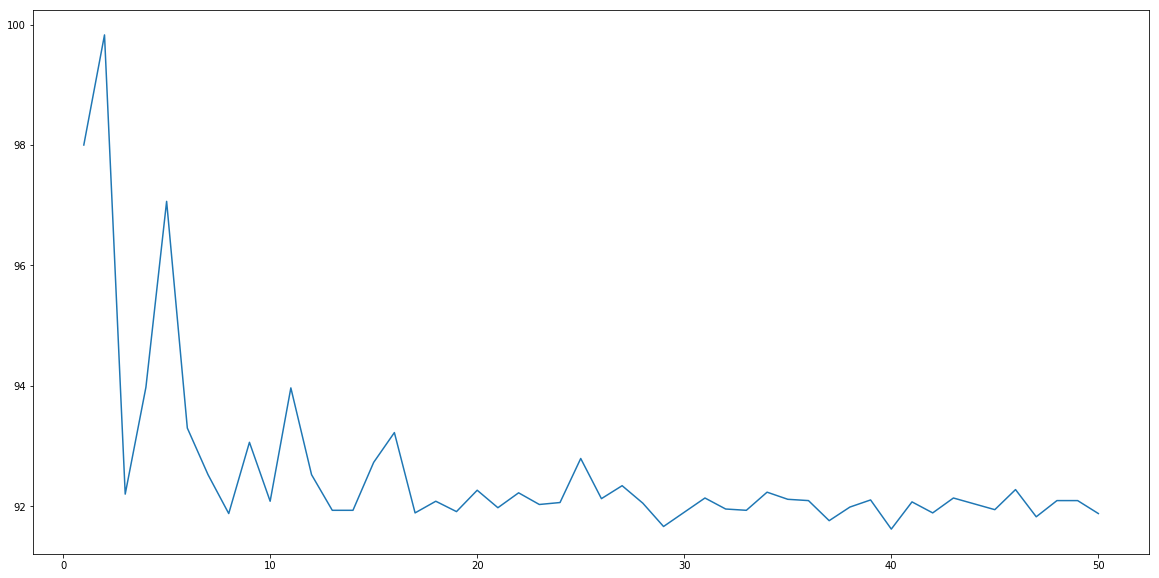

In [23]:
plt.figure(figsize = (20,10))
apply_HBOS(df, high = 50, testSize = 0.2)

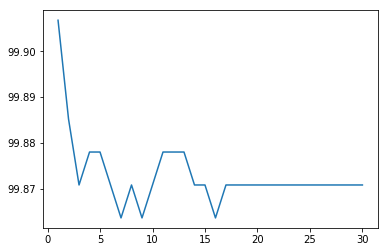

In [24]:
apply_KNN(df, high = 30)

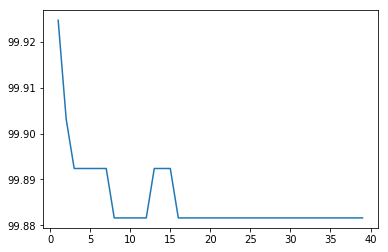

In [25]:
apply_KNN(df, testSize = 0.2, high = 39)

In [26]:
df_bc = pd.read_csv("winconsin_breast_data.csv", header = None)
df_bc.columns = get_excel_columns(len(df_bc.columns))
df_bc.head()

,A,B,C,D,E,F,G,H,I,J,...,V,W,X,Y,Z,AA,AB,AC,AD,AE
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,o
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,o
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,o
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,o
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,o


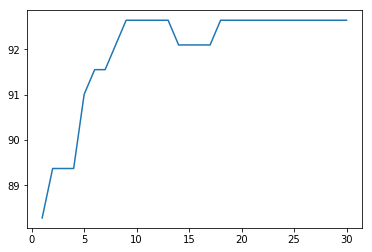

In [27]:
apply_LOF(df_bc, high = 30, contamination = 0.1)

In [28]:
df_bc = pd.read_csv("winconsin_breast_data.csv", header = None)
df_bc.columns = get_excel_columns(len(df_bc.columns))
df_bc

,A,B,C,D,E,F,G,H,I,J,...,V,W,X,Y,Z,AA,AB,AC,AD,AE
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.26540,0.4601,0.11890,o
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.18600,0.2750,0.08902,o
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.24300,0.3613,0.08758,o
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.25750,0.6638,0.17300,o
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.16250,0.2364,0.07678,o
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,14.59,22.68,96.39,657.1,0.08473,0.13300,0.10290,0.03736,0.1454,0.06147,...,27.27,105.90,733.5,0.10260,0.31710,0.3662,0.11050,0.2258,0.08004,n
363,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,0.06570,...,37.16,82.28,474.2,0.12980,0.25170,0.3630,0.09653,0.2112,0.08732,n
364,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,...,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321,n
365,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,0.05502,...,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905,n


In [29]:
test_vals = [0.5,0.4,0.3,0.2,0.1]

In [30]:
test_vals

[0.5, 0.4, 0.3, 0.2, 0.1]

In [ ]:
for i in test_vals:
    apply_KNN(df, high = 30, testSize = i)

In [ ]:
plt.figure(figsize = (20,10))
for i in test_vals:
    apply_HBOS(df, high = 50, testSize = i)
plt.title("Varying test_set size")
plt.legend(test_vals)

In [ ]:
plt.figure(figsize = (20,10))
for i in range(1,5):
    apply_HBOS(df, high = 50, randomState = i)
plt.title("Varying RandomState")
plt.legend(range(1,10))

In [ ]:
plt.figure(figsize = (20,10))
apply_HBOS(df, high = 50, randomState = 9)

In [ ]:
apply_LOF(df, high = 50) #LOF

In [ ]:
apply_LOF_novelty(df_bc)

In [ ]:
def roc_KNN(df, k = 20, testSize = 0.3, randomState = 4):
    X = df[get_excel_columns(len(df.columns) - 1)].values.astype(float)
    X = StandardScaler().fit(X).transform(X.astype(float))
    y = df.iloc[:, -1]
    y = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = randomState)
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train, y_train)
    #get probability scores
    y_scores = KNN.predict_proba(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_scores[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    #plot
    plt.figure(figsize = (10,10))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of kNN')
    plt.show()

In [ ]:
roc_KNN(df)


In [ ]:
df_thyroid = pd.read_csv("thyroid.csv")
df_thyroid.columns = get_excel_columns(len(df_thyroid.columns))
df_thyroid

In [ ]:
apply_LOF_novelty(df_thyroid, high = 100)

In [ ]:
apply_LOF(df_thyroid, high = 50)